## Geospatial features 


This notebook is to compare the geospatial features against the model performance (R$^2$ and NSE). 

In [1]:
#Import 
%matplotlib inline
import pandas as pd
import matplotlib.colors as colors
#from matplotlib_scalebar.scalebar import ScaleBar
#import contextily as cx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
#from functions import mapplot
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
import numpy as np
import seaborn as sns
from shapely.geometry import Point, MultiPolygon, Polygon, GeometryCollection,mapping
from shapely import ops
import rasterio
from rasterio.plot import show
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from scipy import stats
import rasterio.mask
from matplotlib.colors import LinearSegmentedColormap
import richdem as rd
import pcraster as pc
import subprocess
from osgeo import gdal
from IPython.display import display, Markdown

In [2]:
patht="D:/Erasmus/Thesis/"
pathdat=patht+"/data/"

pathshp=pathdat+"/SHP/SHP2/"
pathrast=pathdat+"/Raster/"
pathpick=pathdat+"/Pickle/"
pathfig=patht+"/Figures/"
pathfig2=r"D:\FOSTER\Figs/"

pathg=r'D:\Erasmus\Thesis\data\resultsCNN/'

## Load and plot metrics 

In [3]:
#Load files
folder2 = Path(pathg+"wihtoutRH/")
df_norh = pd.concat([
    pd.read_csv(fname)
    for fname in folder2.glob("summary_CNN_*.txt")])

In [4]:
df_norh.loc[df_norh.NSE<0, 'NSE'] = 0

In [5]:
dfcomb=pd.concat([df_norh.reset_index().NSE, 
                  df_norh.reset_index().r2,df_norh.reset_index().Bias ], axis=1)

## Geospatial analyses

In [6]:
#Load shapefiles
gw_sel=gpd.read_file(pathshp+"GWF2.shp") #vector with the wells and locations

#LS GIS information OSM
waterbodies=gpd.read_file(pathshp+"waterbodiesND.shp") #to add in the background map
waterways=gpd.read_file(pathshp+"waterwaysND.shp")

#Administrative boundaries
germany_states = gpd.read_file(pathshp+"DEU_adm1.shp")
ND=germany_states[germany_states.NAME_1== "Niedersachsen"]

In [7]:
#BGR hydrogeology map 1:250k clipped for Lower Saxony
hydrogeologischeND=gpd.read_file(pathshp+"hydrogeologischeND.shp")

#LS GIS information OSM
citiesND=gpd.read_file(pathshp+"citiesND2.shp")
landuse=gpd.read_file(pathshp+"LS/gis_osm_landuse_a_free_1.shp")
places=gpd.read_file(pathshp+"LS/gis_osm_places_a_free_1.shp")

In [8]:
#Create a column to store the accuracy of the models- this is created in the shapefile that has the wells ID
gw_sel[['NSE_2','r2_2', 'bias']]=np.nan
for i in range(len(df_norh)):
    index=gw_sel.loc[gw_sel.MEST_ID==df_norh.wellid.values[i]].index[0]
    gw_sel.at[index, 'NSE_2'] = df_norh.NSE.values[i]
    gw_sel.at[index, 'r2_2'] = df_norh.r2.values[i]
    gw_sel.at[index, 'bias'] = df_norh.Bias.values[i]
        
    

In [113]:
c=gw_sel.NSE_2.copy()
c.dropna(inplace=True)
c.describe()

count    505.000000
mean       0.583744
std        0.169372
min        0.000000
25%        0.487192
50%        0.617615
75%        0.708461
max        0.869102
Name: NSE_2, dtype: float64

### Plot NSE and R2

In [9]:
#Project shapefiles for mapping
proj_coor=4647
gw_sel=gw_sel.to_crs(epsg=proj_coor)
waterbodies=waterbodies.to_crs(epsg=proj_coor)
waterways=waterways.to_crs(epsg=proj_coor)

hydrogeo=hydrogeologischeND.to_crs(epsg=proj_coor)
cities=citiesND.to_crs(epsg=proj_coor)
land_use=landuse.to_crs(epsg=proj_coor)
germany_states=germany_states.to_crs(epsg=proj_coor)
ND=ND.to_crs(epsg=proj_coor)


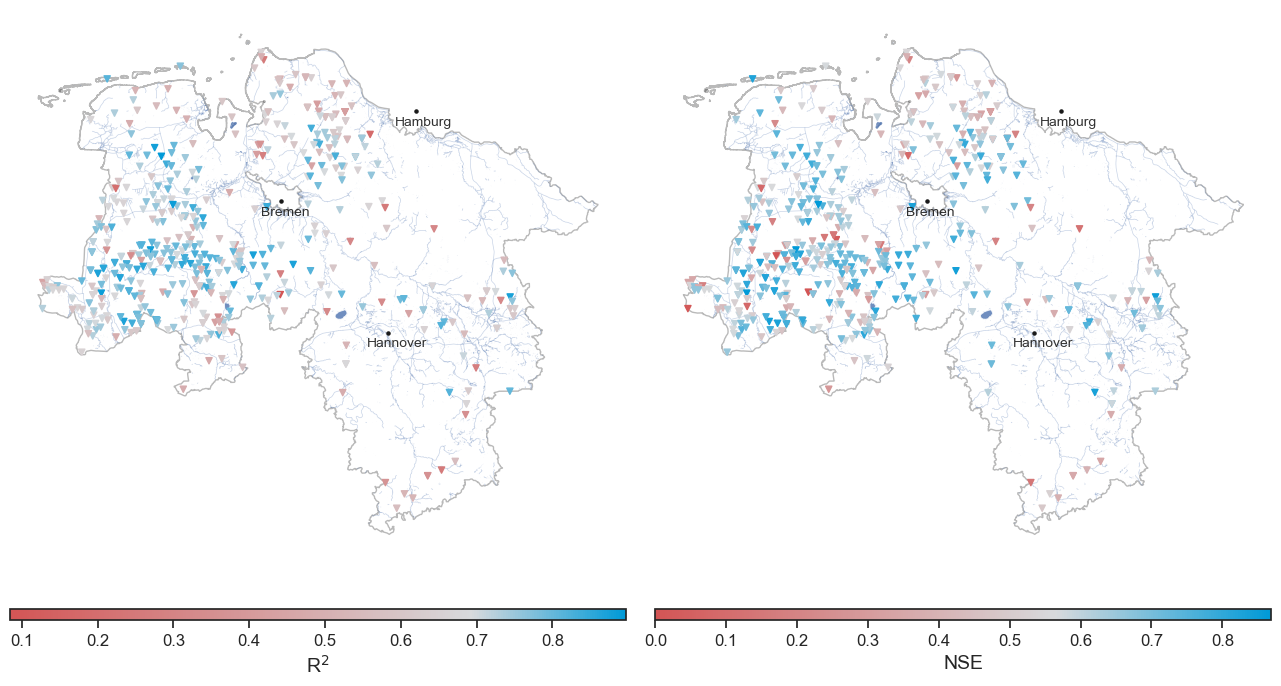

In [195]:
sns.set_theme(style="ticks")
bound=germany_states.to_crs(gw_sel.crs.to_string()) 
#cmap="coolwarm_r"
#cmap='plasma'

cmap = LinearSegmentedColormap.from_list( 'mycmap', [(0, '#d35555'),(0.75, '#d8dadc'), (1, '#009ad8')])
cmap2 = LinearSegmentedColormap.from_list( 'mycmap', [(0, '#d35555'),(0.65, '#d8dadc'), (1, '#009ad8')])
#cmap='viridis_r'
#cmap2='viridis_r'

fig, (gw, gw2) = plt.subplots(ncols=2, figsize=(13, 8))
gw=mapplots(column='r2_2',cmap=cmap,bound=bound,axs=gw, gws=gw_sel,
            waterbodies=waterbodies,waterways=waterways, cities=cities,
            ND=ND, marker='v', normalize=True)
gw2=mapplots(column='NSE_2',cmap=cmap2,bound=bound,axs=gw2, gws=gw_sel,
             waterbodies=waterbodies,waterways=waterways, cities=cities, 
            ND=ND, marker='v', normalize=True)

plt.tight_layout()
pathfig="D:\FOSTER\Figs/" 
plt.savefig(pathfig+"PT2.jpg",bbox_inches="tight",dpi=250)

In [308]:
def mapplots(column,cmap,bound,axs,gws, 
             waterbodies,waterways,cities,ND, vcenter=None,marker='v',
             normalize=True,ls=12,fs=14, ms=20, norm=None, scheme=None, k=None, legend_kwds=None, bounds=None):
    
    gw=gw_sel.plot(ax=axs,figsize=(10, 10),column=column, markersize=ms,
               marker="v", facecolor=None,cmap=cmap, zorder=3, norm=norm)
    wb=waterbodies.plot( ax=axs, alpha=0.8, color='b', linewidth=0.8, zorder=1)
    ww=waterways.plot( ax=axs, alpha=0.3, color='b', linewidth=.5,zorder=2)
    #gdff=gdf.plot( ax=gw, alpha=0.5, color='r',markersize=12,zorder=2)
    cit=cities.plot( ax=gw, alpha=1, color='k',markersize=5,zorder=2)
    NS=ND.boundary.plot( ax=axs, alpha=0.3, edgecolor='k', linewidth=1, 
                        zorder=1)

 
    cbar=gw.get_figure().colorbar(axs.get_children()[0], ticks=bounds, orientation='horizontal', pad=0.02, aspect=20, shrink=0.4)
    cbar.set_label('BIAS', fontsize=14)

        

        
    for x, y, label in zip(cities.geometry.x, cities.geometry.y, cities.name):
        NS.annotate(label, xy=(x, y), xytext=(-15, -10), textcoords="offset points", fontsize=10, color="k", alpha=0.9)

    #for x, y, label in zip(gw_sel.geometry.x[:len(df)], gw_sel.geometry.y[:len(df)], gw_sel.MEST_ID[:len(df)]):
    #    gw.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=5)

    gw.spines['top'].set_visible(False)
    gw.spines['right'].set_visible(False)
    gw.spines['bottom'].set_visible(False)
    gw.spines['left'].set_visible(False)
    
    gw.get_xaxis().set_ticks([])
    gw.get_yaxis().set_ticks([])

    #scalebar
    #scalebar = ScaleBar(0.5, "m", dimension="si-length", length_fraction=0.10, location="lower left")
    #gw.add_artist(scalebar)
    #startx, endx = gw.get_xlim()
    #starty, endy = gw.get_ylim()


    return axs

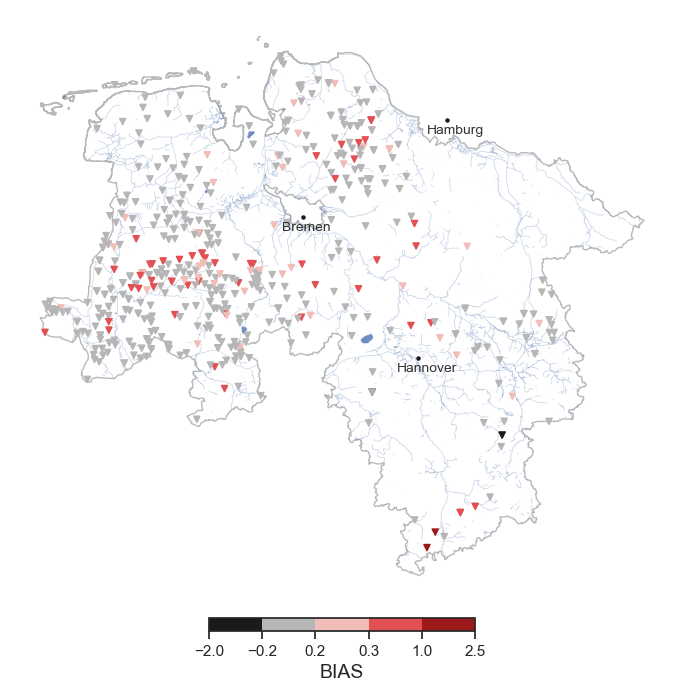

In [310]:
sns.set_theme(style="ticks")
bound=germany_states.to_crs(gw_sel.crs.to_string()) 
#cmap="coolwarm_r"
#cmap='plasma'

cmap = LinearSegmentedColormap.from_list( 'mycmap', [(0, '#d35555'),(0.6, '#d8dadc'), (1, '#009ad8')])
cmap2 = LinearSegmentedColormap.from_list( 'mycmap', [(0, '#d35555'),(0.5, '#d8dadc'), (1, '#009ad8')])
#cmap='viridis_r'
#cmap2='viridis_r'

colors = ['k', '#B6B6B6', '#F1BDB9', '#e35053','#9c191b']
cmap = ListedColormap(colors)
bounds = [-2,-0.2, 0.2, 0.3,1, 2.5]
norm = BoundaryNorm(bounds, cmap.N)

fig, gw3 = plt.subplots(ncols=1, figsize=(7, 8))
gw3=mapplots(column='bias',bound=bound,axs=gw3, gws=gw_sel,
             waterbodies=waterbodies,waterways=waterways, cities=cities, 
            ND=ND, marker='v', cmap=cmap, norm=norm, normalize=False, bounds=bounds)
plt.tight_layout()
pathfig="D:\FOSTER\Figs/" 
plt.savefig(pathfig+"PT_BIAS.jpg",bbox_inches="tight",dpi=250)

## Geospatial relations

Aquifer type  \
Aquifer material \
Filter depth \
Elevation \
Waterworks OSM \
CORINE land cover \
Multi-Order Hydrologic Position \
Distance to the sea\
Distance to the waterways \
Impervious layer\
Geomorphology \
Long-term recharge \
LAI: leaf area index\
Slope\
Drainage density\
Topographic Wetness Index


### Distribution of wells according to the hydrogeology

Information in the hydrogeological map

HE_B Hydrogeologic unit, abbreviation 01K (1-4)A \
HE_B_BEZ Hydrogeologic unit, designation Quaternary (unclassified) \
GA Rock type, abbreviation S \
__GA_bez__ Rock type, designation Sedimentary \
VF consolidation, abbreviation L \
__VF_bez__ consolidation, designation unconsolidated rock -- Lockergestein (loose rock), Festgestein (hard rock) \
HA Cavity type, abbreviation P \
__HA_bez__ Cavity type, designation pores \
GC Geochemical rock type, abbreviation s \
__GC_bez__ Geochemical rock type, designation siliceous \
KF Permeability (m/s), abbreviation 11 \
__KF_bez__ Permeability (m/s), designation highly variable \

LChar Conductor character, abbreviation GWG/GWL \
__LChar_bez__ Conductor character, designation groundwater conductor/groundwater conductor \
__Litho__ Lithology Gravel, sand, silt \
Strat1 Stratigraphy (General) Quaternary \
Start2 Stratigraphy (Detail) Quaternary 

In [16]:
#Intersect map with the well locations
hgint=gpd.overlay(gw_sel, hydrogeo, how='intersection')

All wells are located in sedimentary rock-type

In [17]:
dic_VF={'Lockergestein':'Loose rock',
'Festgestein': 'Hard rock' }
hgint['VF_bez_dic']=hgint['VF_bez'].map(dic_VF)

dic_HA={'Poren':'Porous',
'Kluft': 'Fracture','Kluft/Karst':'Mixed','Kluft/Poren':'Mixed'}
hgint['HA_bez_dic']=hgint['HA_bez'].map(dic_HA)

#Permeability (m/S)
dict_kf={3:'Medium (>10$^{-4}$ - 10$^{-3}$)',
9: 'Medium to moderate  (>10$^{-5}$ - 10$^{-3}$)' , 11:'Highly variable', 5:'other', 4:'other', 10:'other'}
hgint['kf_dic']=hgint['kf'].map(dict_kf)

dic_litho={'Sand, Kies':'Sand, gravel',
'Sand, Feinsand, Schluff, untergeordnet Kies': 'Sand, fine sand, silt', 'Kalkstein, Mergelstein':'Other',
           'Tonstein, Sandstein, Dolomitstein, Kohle':'Other'}
hgint['Litho_dic']=hgint['Litho'].map(dic_litho)


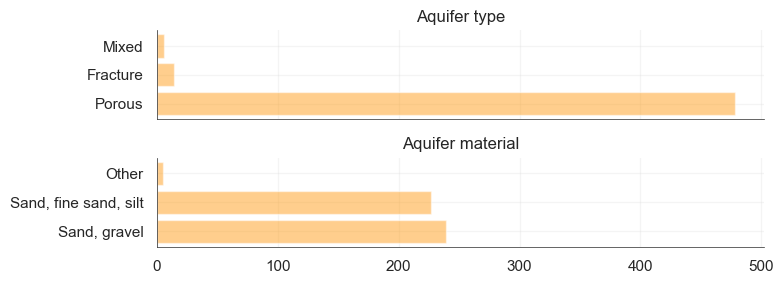

In [14]:
column=['HA_bez_dic','Litho_dic']
#column=['HA_bez_dic']
sns.set_theme(style="white")
fig, axs = plt.subplots(2, 1, figsize=(8,3), sharex=True)
c=0
color=["#ff9f1c","#ff9f1c"]
for cl in column:
    hgintcl=pd.DataFrame(hgint[cl].value_counts())
    order=hgintcl.index
    piep=axs[c].barh(hgintcl[cl].index, hgintcl[cl].values, color=color[c],alpha=0.5)
    c+=1

axs[0].set_title("Aquifer type")
axs[1].set_title("Aquifer material")
axs[0].grid(alpha=0.2)
axs[1].grid(alpha=0.2)

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['left'].set_linewidth(0.5)
axs[0].spines['bottom'].set_linewidth(0.5)

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_linewidth(0.5)
axs[1].spines['bottom'].set_linewidth(0.5)

plt.tight_layout()  
#plt.savefig(pathfig+"hydrogeoprop.pdf",bbox_inches="tight")

## 1. Depth to groundwater 

In [42]:
#Load additional information of GWL observations
root=pathdat+'/Grundwasserstandsdaten/'
basisdaten=pd.read_csv(root+'PROJEKT_BASISDATEN.txt', sep=';')
#monatswert=pd.read_csv(root+'PROJEKT_MONATSWERTE.txt', sep=';')

basisdatenc=basisdaten.set_index(basisdaten.MEST_ID)
gw_selc= gw_sel.set_index(gw_sel.MEST_ID)
#Join gw_sel with the additional information contained in basisdaten file
gw_seladd=gw_selc.join(basisdatenc, lsuffix='', rsuffix='_2') 

In [43]:
gw_seladd['FUK2']=gw_seladd['FUK'].apply(lambda x: x.replace(',','.')).astype(float)
gw_seladd['FOK2']=gw_seladd['FOK'].apply(lambda x: x.replace(',','.')).astype(float)
gw_seladd['GOK_NN2']=gw_seladd['GOK_NN'].apply(lambda x: x.replace(',','.')).astype(float)
gw_seladd['MBP_NN2']=gw_seladd['MBP_NN'].apply(lambda x: x.replace(',','.')).astype(float)
gw_seladd['MBP-GOK']=gw_seladd['MBP_NN2'] - gw_seladd['GOK_NN2']

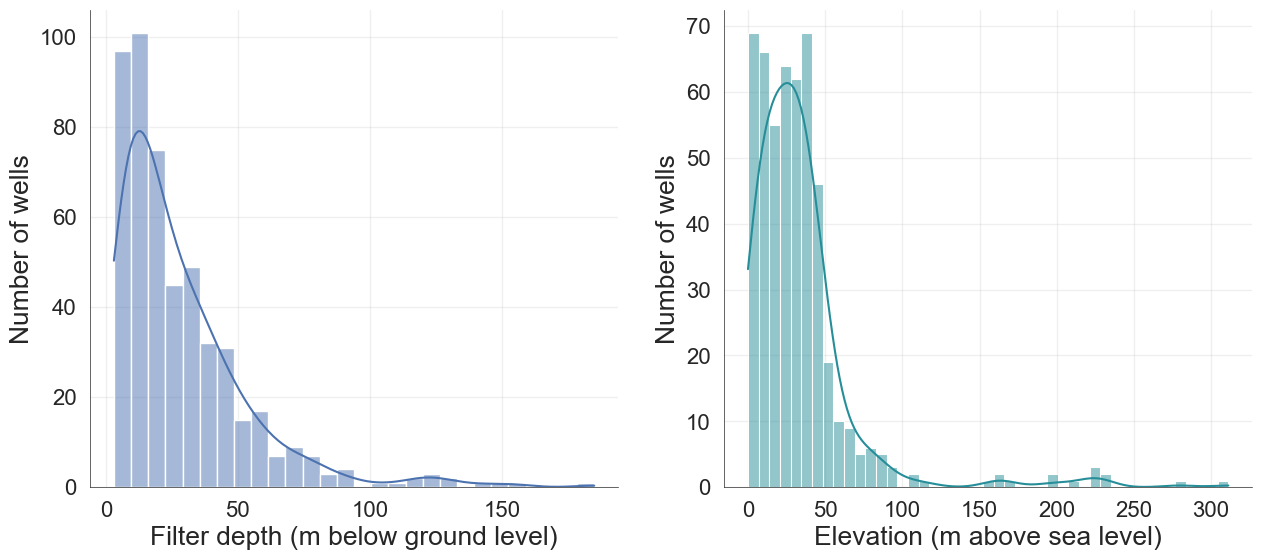

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(15,6.2))
sns.set_theme(style="white")
fs=19
ts=16
sns.histplot(data=gw_seladd['FUK2'].sort_values(), kde=True,  ax=axs[0])

axs[0].set_ylabel('Number of wells', fontsize=fs)
axs[0].set_xlabel('Filter depth (m below ground level)', fontsize=fs)
axs[0].grid(True, alpha=0.3)
#axs[0].set_title("(a)")
axs[0].tick_params(axis='both', which='major', labelsize=ts)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['left'].set_linewidth(0.5)
axs[0].spines['bottom'].set_linewidth(0.5)


#plt.histplot(np.arange(len(gw_seladd)),gw_seladd['FOK2'].sort_values(), '.-')
sns.histplot(data=gw_seladd['GOK_NN2'].sort_values(), kde=True, color='#268e99', ax=axs[1])
#plt.hist(gw_seladd['FUK2'].sort_values(), color='#3097b6', lw=1)
axs[1].set_ylabel('Number of wells', fontsize=fs)
axs[1].set_xlabel('Elevation (m above sea level)', fontsize=fs)
axs[1].grid(True, alpha=0.3)
axs[1].tick_params(axis='both', which='major', labelsize=ts)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_linewidth(0.5)
axs[1].spines['bottom'].set_linewidth(0.5)
#axs[1].set_title("(b)")
plt.savefig(pathfig+"filterdepth_groundlevel.png",bbox_inches="tight",dpi=300)

-0.19032896735678112


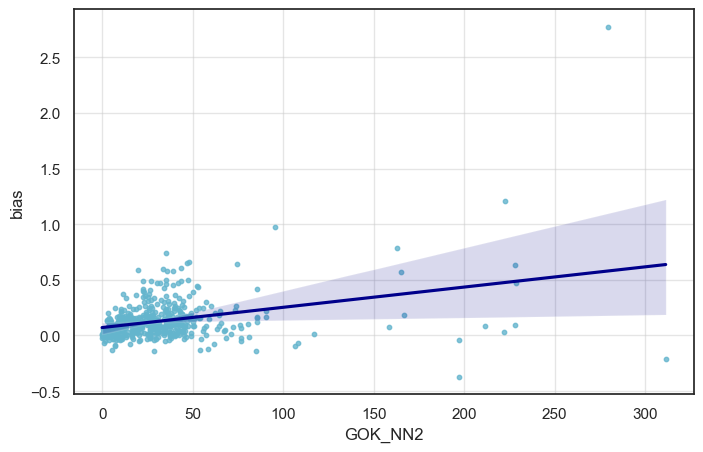

In [45]:
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(8,5))
dfaux=gw_seladd.sort_values(by="GOK_NN2")[:]
slope, intercept, r_value, p_value, std_err = stats.linregress(gw_seladd['GOK_NN2'],
                                                               gw_seladd["r2_2"])
print(r_value)
cp=sns.regplot(ax=ax,x="GOK_NN2", y="bias", data=dfaux[:], fit_reg=True, order=1,
 color='darkblue',scatter_kws={"s": 10,"color": "c"})
#cp=sns.regplot(ax=ax,x="GOK_NN2", y="r2", data=gw_seladd.sort_values(by="GOK_NN2"), fit_reg=True, order=2,
#               ci=False, color='darkblue',scatter_kws={"s": 10,"color": "c"})
ax.grid(alpha=0.5)

#plt.savefig('D:/Data/students/mariana/Documents/Figures/Spatial_relations/FOK_r2_2.png',bbox_inches='tight')

In [46]:
# Add time series to the main dataframe
gw_sel['GOK_NN']=gw_seladd['GOK_NN2'].values
gw_sel['FOK']=gw_seladd['FOK2'].values
gw_sel['FUK']=gw_seladd['FUK2'].values

## 2.1. Waterworks OSM

In [47]:
#Load the corine land cover 2008 
waterworks_points=gpd.read_file(pathshp+"/waterworks/wasserwerk_point.shp")
waterworks_lines=gpd.read_file(pathshp+"/waterworks/wasserwerk_line.shp")
waterworks_polys=gpd.read_file(pathshp+"/waterworks/wasserwerk_pol.shp")
waterworks_point=waterworks_points.to_crs(epsg=proj_coor)
waterworks_line=waterworks_lines.to_crs(epsg=proj_coor)
waterworks_poly=waterworks_polys.to_crs(epsg=proj_coor)

In [ ]:
#points=Point(coastlines.geometry[0].coords[0])
l=[]
for ww in waterworks_point.geometry:
    for i in ww :
        l.append(Point(i))
        
for wwl in waterworks_lines.geometry:
    for i in wwl.coords :
        l.append(Point(i))
        
for wwp in waterworks_polys.geometry:
    map_pol=mapping(wwp)['coordinates']
    for polcoor in map_pol :
        [l.append(Point(coords[1],coords[0])) for coords in polcoor]

        
gdfww=gpd.GeoDataFrame(index=np.arange(len(l)), crs='epsg:'+str(proj_coor), geometry=l)

In [ ]:
gw_selc=gw_sel.copy()
gdfs = gpd.GeoDataFrame(geometry=gw_selc.geometry).to_crs("EPSG:"+str(proj_coor))
dmtca=gdfs.geometry.apply(lambda g: gdfww.distance(g))
vdist=[]
for i in range(len(dmtca)):
    vdist.append(min(dmtca[dmtca.columns][i:i+1].values[0])/1000)
gw_sel['dist_pww']=vdist  


<IPython.core.display.Javascript object>


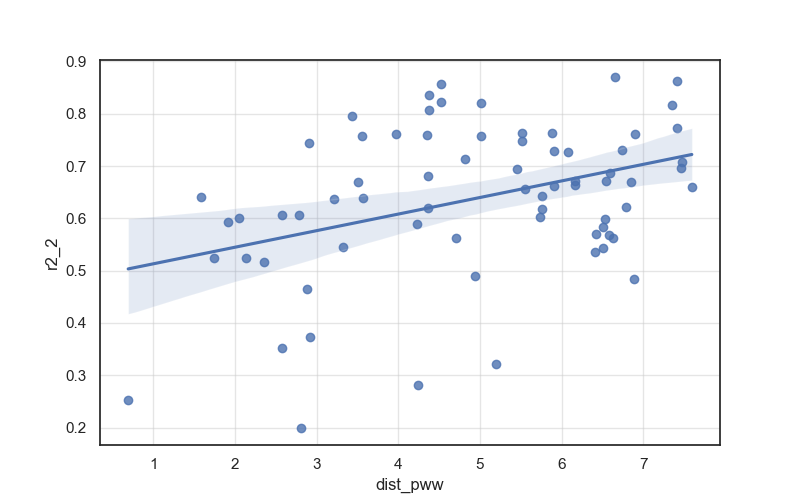

0.3863738587877114


In [ ]:
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(8,5))
data=gw_sel.sort_values(by="dist_pww")[:70]
cp=sns.regplot(ax=ax,x="dist_pww", y="r2_2", data=data, fit_reg=True)
ax.grid(alpha=0.5)

slope, intercept, r_value, p_value, std_err = stats.linregress(data["dist_pww"],
                                                                   data["r2_2"])
#print(stats.spearmanr(data["dist_pww"],data["r2_2"]))
print(r_value)

## 3. Intersection with Corine-land cover data

Check the relation witht the CORINE Land Cover (CLC) inventory for 2019. 
Downloaded from https://land.copernicus.eu/pan-european/corine-land-cover

It consists of 44 classes described here https://land.copernicus.eu/user-corner/technical-library/corine-land-cover-nomenclature-guidelines/html

'112'--> __Discontinuous urban fabric (Artificial Surfaces )__\
'121'--> Industrial or commercial units (Artificial Surfaces )\
'124'--> Airports (Artificial Surfaces )\
'142'--> Sport and leisure facilities (Artificial Surfaces )\
'211'--> __Non-irrigated arable land (Agricultural areas )__\
'231'--> __Pastures (Agricultural areas )__\
'311'--> Broad-leaved forest (Forest and seminatural areas )\
'312'--> __Coniferous forest  (Forest and seminatural areas )__\
'313'--> Mixed forest (Forest and seminatural areas )\
'322'--> Moors and heathland  (Forest and seminatural areas )\
'412'--> Peatbogs (Wetlands)\
'512'--> Water bodies 

note: the bold categories are the most relevant 

In [20]:
#Load the corine land cover 2008 
clc=gpd.read_file(pathshp+"clc2018/clc2018_LSr.shp")
clcs=clc.to_crs(epsg=proj_coor)

In [21]:
#Intersect the layer and the wells ID
clcsint=gpd.overlay(gw_sel, clcs, how='intersection')

In [22]:
dic_cat={'112':'Discontinuous urban fabric',
'121': 'Industrial or commercial units ',
'124' : 'Airports',
'142': 'Sport and leisure facilities',
'211': 'Non-irrigated arable land' ,
'231': 'Pastures',
'311' : 'Broad-leaved forest', 
'312': 'Coniferous forest' , 
'313': 'Mixed forest' ,
'322': 'Moors and heathland' , 
'412': 'Peatbogs' ,
'512':' Water bodies' }

#Map dictionary into a new column to recognize which code corresponds to which definition
clcsint['name']=clcsint['Code_18'].map(dic_cat)
clcs['name']=clcs['Code_18'].map(dic_cat)

In [23]:
cl='name'
clcsintcl=pd.DataFrame(clcsint[cl].value_counts())
Lcat=clcsintcl.loc[clcsintcl.name<4].index
ind=clcsint.loc[clcsint[cl].isin(Lcat)].name.index
clcsint.loc[ind, cl] = "others"


In [24]:
clcsintcl=pd.DataFrame(clcsint[cl].value_counts())
clcsintcl=clcsintcl.drop(index=("others"))
order=clcsintcl.index

In [ ]:
dic=clcclass.name.to_dict()
clcsint['name_sor']=clcsint.name.map(dic)
clcsint_sort=clcsint.sort_values(by='name_sor',ascending=False)
clcsint_sort1=clcsint_sort.loc[clcsint_sort.name!="others"]
clcsint_sort2=clcsint_sort1.rename(columns={"r2": "r$^2$"})

<IPython.core.display.Javascript object>


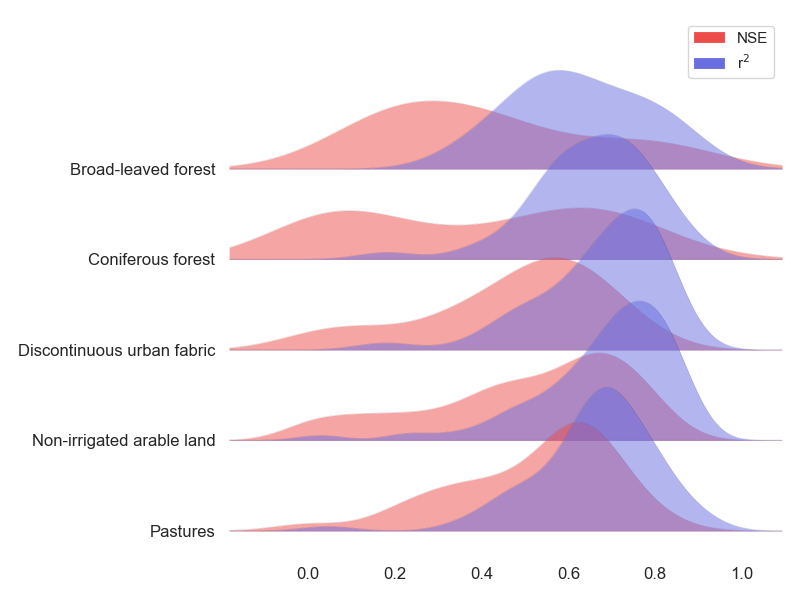

(<Figure size 800x600 with 6 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>])

In [ ]:
col='name'
joyplot(
    data=clcsint_sort2[['NSE',"r$^2$", col]], 
    by=col,
    color=[ '#eb4d4b','#686de0'],
    lw=0.1,
    alpha=0.5,
    legend=True,
    figsize=(8, 6))

### 3.1. Intersection with 4 km buffer
Inntersect buffer with the shape of corine land covers.

In [27]:
#Set the influence area to 1km 
clcsint['buffer']=clcsint.buffer(1000)

gw_sel['buff_1km']=gw_sel.buffer(1000)
#b=clcsint.buffer(1000)
#b.to_file('D:/Data/students/mariana/data/test.shp')  

In [ ]:
#clcs is the shapefile of corine land cover
rectangles=clcs.geometry[:]
names_dic=clcs.name
wellid=clcsint.MEST_ID # To make sure the well id corresoinds with the buffer
names=clcs.Code_18
dfs, wids=[] , []

count=0
for c in clcsint['buffer'].geometry:
   
    vnames, vnamesdic, geotypes, geoms, parea=[] , [], [] ,[] ,[]

    for r, nm, nmdic in zip(rectangles,names,names_dic):
        # create intersection 
        inters=c.intersection(r)
        #Check geometry type
        geoms.append(inters)
        #Store the names of the land covers to associate with every geometry
        vnames.append(nm)
        vnamesdic.append(nmdic)
        geotypes.append(inters.geom_type)

    # create shapely GeometryCollection
    geom_collection = GeometryCollection(geoms)

    pols, vnams, vnamsdic=[], [], []
    for i,vn, vndic, gt in zip(geom_collection, vnames,vnamesdic, geotypes):
        if gt == 'Polygon':
            poly=Polygon(i)
        else:
            poly=MultiPolygon(i) 

        if not poly.is_empty:
            pols.append(poly)
            vnams.append(vn)
            vnamsdic.append(vndic)
            parea.append(poly.area/10E6) # add area in km2
    
    
    
    prop=parea/np.sum(parea)
    d = {'col1': vnams, 'names':vnamsdic ,'geometry': pols, 'area':parea, 'prop':prop}
    df = gpd.GeoDataFrame(d, crs="EPSG:4647") #(assign epsg)
    dfs.append(df)
    wids.append(wellid[count])
    count+=1
    #df.to_file('D:/Data/students/mariana/data/test3.shp')

<IPython.core.display.Javascript object>


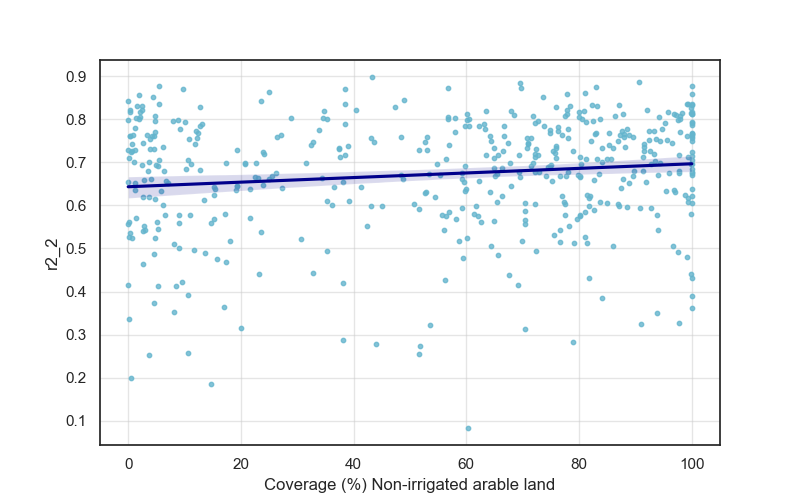

<IPython.core.display.Javascript object>


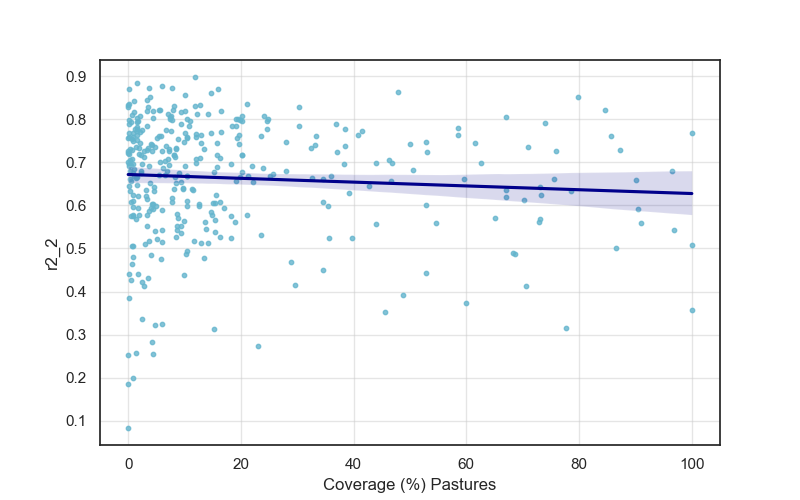

<IPython.core.display.Javascript object>


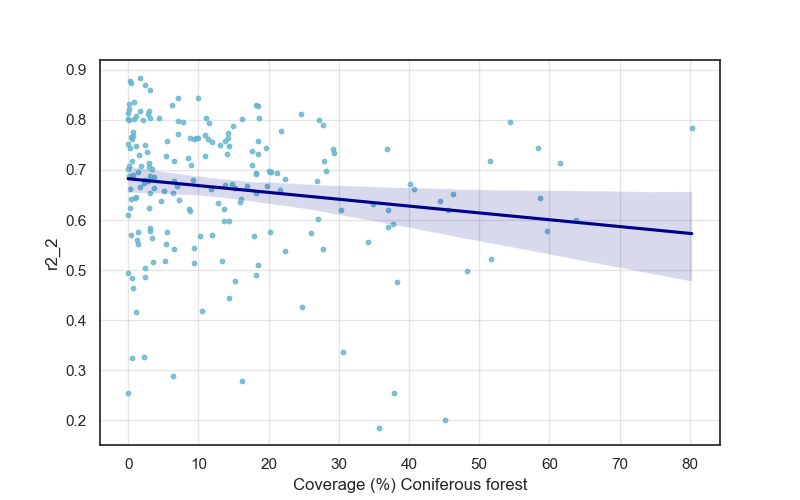

<IPython.core.display.Javascript object>


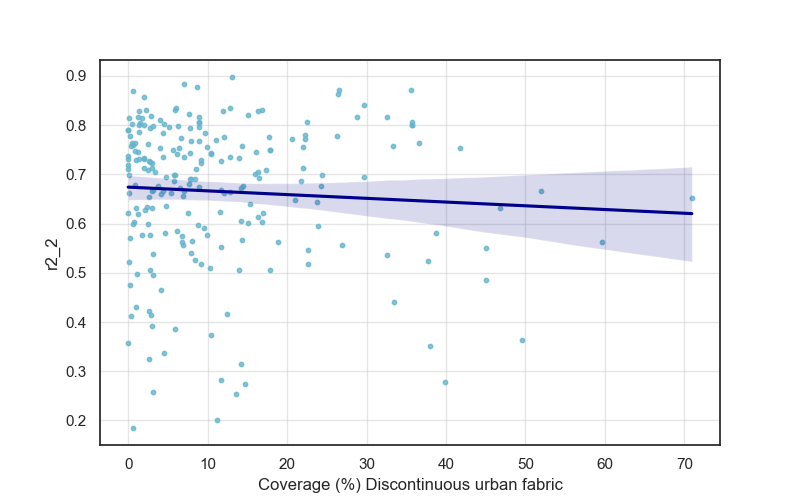

<IPython.core.display.Javascript object>


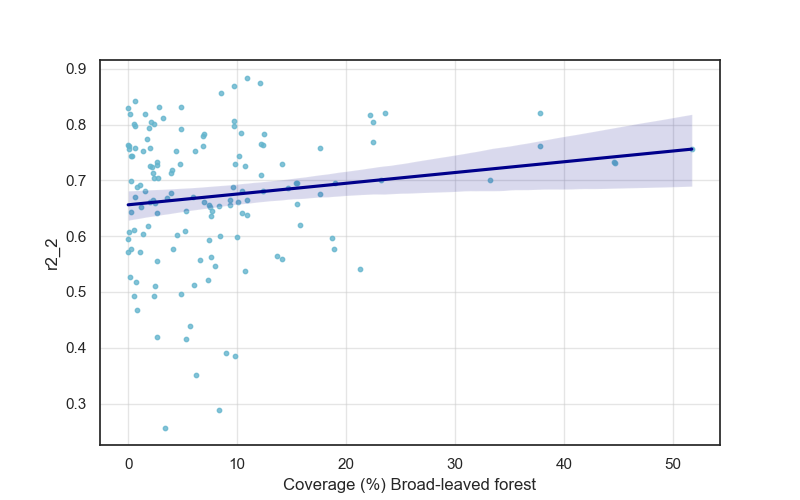

In [ ]:

#List of the code for the main categories of clc in the study area
lcod=['211','231','312','112','311']
catname=[ 'Non-irrigated arable land' , 'Pastures','Coniferous forest' , 
         'Discontinuous urban fabric', 'Broad-leaved forest']

for categ, name in zip(lcod,catname):
    li=[]
    for datf in dfs:
        pr=datf[datf.col1==categ].prop
        if not pr.empty:
            li.append(pr.values[0]*100)

        else:
            li.append(0.0)


    #gw_sel['prop_'+categ]=np.zeros(len(gw_sel))
    gw_selaux=gw_sel.loc[gw_sel.MEST_ID.isin(wids)]
    gw_selaux['prop_'+categ]=li
    gw_selaux1=gw_selaux.loc[gw_selaux['r2_2']>0]
    gw_selaux2=gw_selaux1.loc[gw_selaux1['prop_'+categ]>0]

    selcol=['MEST_ID']+list(gw_selaux.columns[-1:])
    gw_sel=gw_sel.merge(gw_selaux[selcol],how='left',left_on='MEST_ID', right_on='MEST_ID')
    
    
    sns.set_theme(style="white")
    fig, ax = plt.subplots(figsize=(8,5))
    cp=sns.regplot(ax=ax,x='prop_'+categ, y="r2_2", data=gw_selaux2.sort_values(by='prop_'+categ), fit_reg=True, order=1,
     color='darkblue',scatter_kws={"s": 10,"color": "c"})
    ax.set_xlabel('Coverage (%) '+name)
    #cp=sns.regplot(ax=ax,x="GOK_NN2", y="r2", data=gw_seladd.sort_values(by="GOK_NN2"), fit_reg=True, order=2,
    #               ci=False, color='darkblue',scatter_kws={"s": 10,"color": "c"})
    ax.grid(alpha=0.5)

## 4. Multi-Order Hydrologic Position

Max project-
J:\NUTZER\Noelscher.M\Studierende\Daten\multiorder_hydrologic_position\germany\time_invariant\raster\v013_1_1\data

There are three main products:\
SD: Distance to the stream \
LP: relative position between the stream and the catchment boundary \
DSD: distance to the stream plus distance to the catchment boundary

#### SD - Distance to stream

<IPython.core.display.Javascript object>


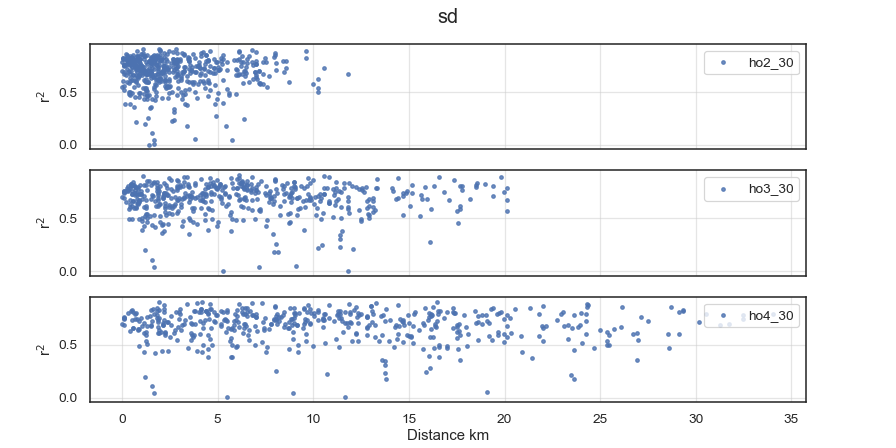

<IPython.core.display.Javascript object>


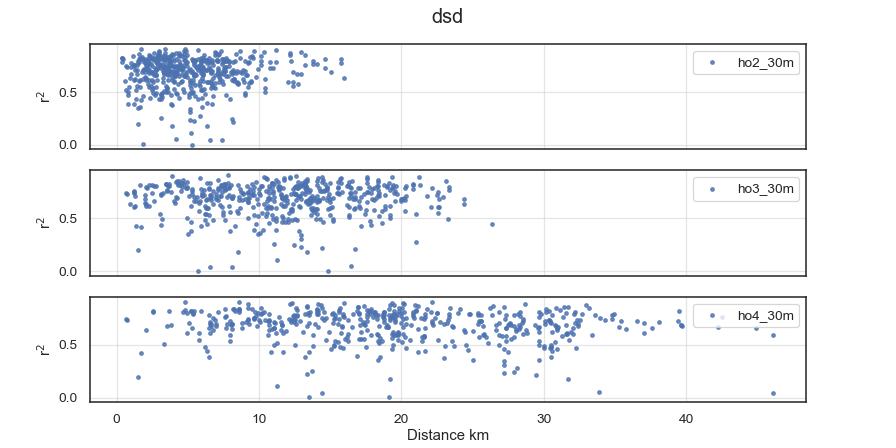

<IPython.core.display.Javascript object>


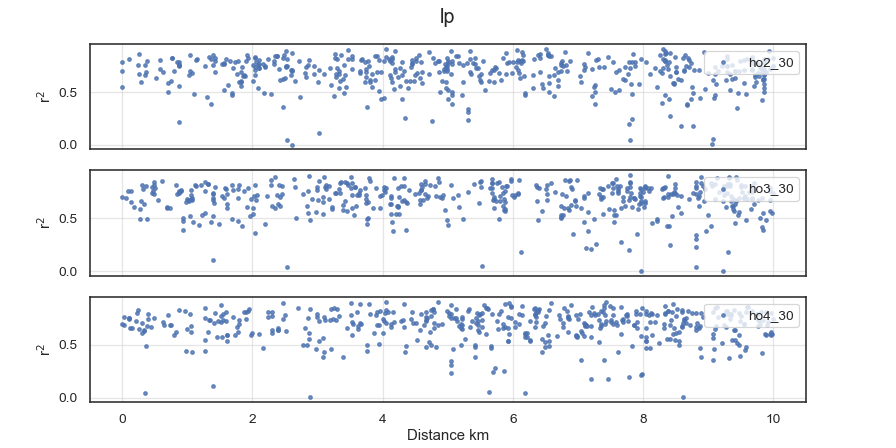

In [ ]:
ni=2
ln=np.arange(2,5)

for nm in ['sd','dsd','lp']:
    fig, ax = plt.subplots(len(ln),1, figsize=(10,5),sharex=True)
    for i in ln:
        ho=rasterio.open("D:/Data/students/mariana/data/Raster/multiorder_hydroposition/mohp_custom_germany_"+nm+"_hydrologicorder"+str(i)+"_30m_4647.tif")

        cl="ho"+str(i)+"_30m_"+nm
        measure='r2'
        coord_list = [(x,y) for x,y in zip(gw_sel['geometry'].x , gw_sel['geometry'].y)]
        gw_sel[cl] = [x[0]/1000 for x in ho.sample(coord_list)]

        cp=sns.regplot(ax=ax[i-ni],x=cl, y=measure, data=gw_sel.sort_values(by=cl), fit_reg=False, label=cl[:-4],
                      scatter_kws={'s':8})
        cp.set(xlabel=None)
        if measure== 'r2':
            ax[i-2].set_ylabel("r$^2$")
        #ax[i-2].set_title(cl)
        ax[i-ni].legend(loc=1)
        ax[i-ni].grid(alpha=0.5)
        fig.supxlabel("Distance km",fontsize=12)
        fig.suptitle(nm, fontsize=16)
        plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.2)


<IPython.core.display.Javascript object>


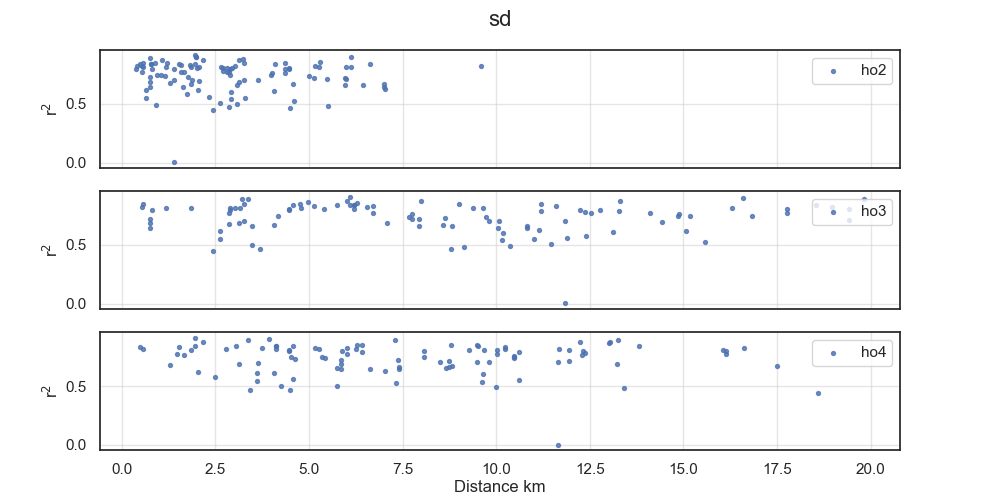

<IPython.core.display.Javascript object>


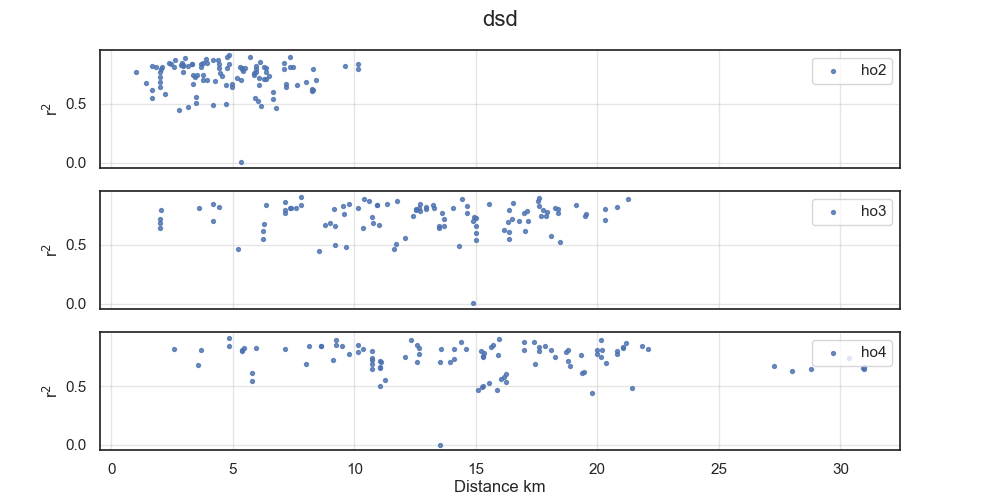

<IPython.core.display.Javascript object>


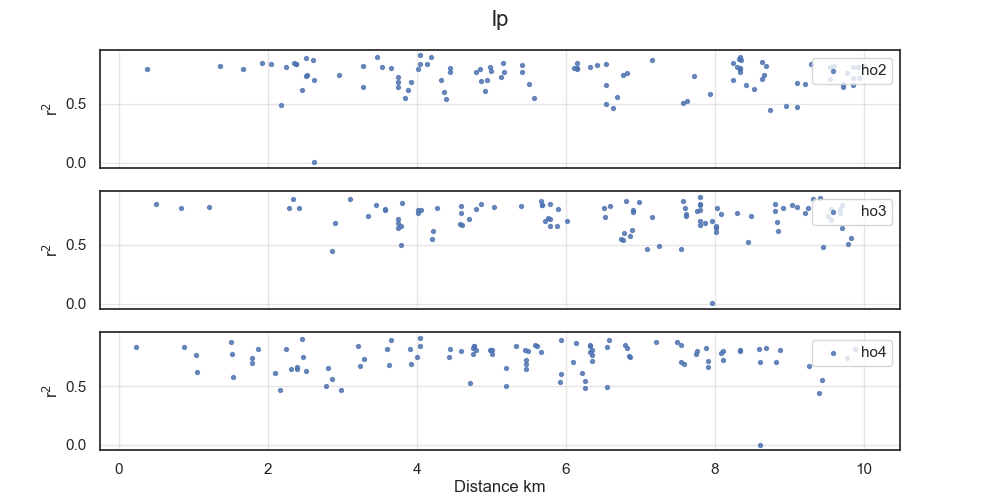

In [ ]:
ni=2
ln=np.arange(2,5)

for nm in ['sd','dsd','lp']:
    fig, ax = plt.subplots(len(ln),1, figsize=(10,5),sharex=True)
    for i in ln:
        ho=rasterio.open("D:/Data/students/mariana/data/Raster/multiorder_hydroposition/mohp_custom_germany_"+nm+"_hydrologicorder"+str(i)+"_30m_4647.tif")

        cl="ho"+str(i)+"_30m"
        measure='r2'
        coord_list = [(x,y) for x,y in zip(gw_selname['geometry'].x , gw_selname['geometry'].y)]
        gw_selname[cl] = [x[0]/1000 for x in ho.sample(coord_list)] #values in km

        cp=sns.regplot(ax=ax[i-ni],x=cl, y=measure, data=gw_selname.sort_values(by=cl), fit_reg=False, label=cl[:-4],
                      scatter_kws={'s':8})
        cp.set(xlabel=None)
        if measure== 'r2':
            ax[i-2].set_ylabel("r$^2$")
        ax[i-ni].legend(loc=1)
        ax[i-ni].grid(alpha=0.5)
        fig.supxlabel("Distance km",fontsize=12)
        fig.suptitle(nm, fontsize=16)
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, 
                        wspace=0.4, hspace=0.2)

## 5. Distance to the sea

In [ ]:
#Load the coastline of Lower Saxony
coastline=gpd.read_file("D:/Data/students/mariana/data/SHP/coastline.shp")
coastlines=coastline.to_crs(epsg=proj_coor)

In [ ]:
#points=Point(coastlines.geometry[0].coords[0])
l=[]
for i in waterways.geometry[0].coords:
    l.append(Point(i))
gdf=gpd.GeoDataFrame(index=np.arange(len(l)), crs='epsg:'+str(proj_coor), geometry=l)

In [ ]:
gw_selc=gw_sel.copy()

In [ ]:
gdfs = gpd.GeoDataFrame(geometry=gw_selc.geometry).to_crs("EPSG:"+str(proj_coor))
dmtca=gdfs.geometry.apply(lambda g: gdf.distance(g))
vdist=[]
for i in range(len(dmtca)):
    vdist.append(min(dmtca[dmtca.columns][i:i+1].values[0])/1000)
gw_sel['dist_coastkm']=vdist  

<IPython.core.display.Javascript object>


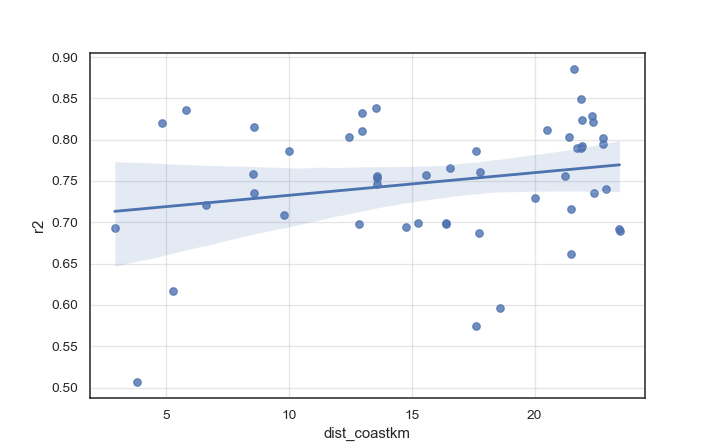

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x="dist_coastkm", y="r2", data=gw_sel.sort_values(by="dist_coastkm")[:50], fit_reg=True)
ax.grid(alpha=0.5)

## 6. Waterways

In [ ]:
#points=Point(coastlines.geometry[0].coords[0])
l2=[]
for j in range(len(waterways.geometry)):
    if waterways.type[j] =='MultiLineString':
        lenmline=len(waterways.geometry[j])
        for ln in range(lenmline):
            l=len(waterways.geometry[j][ln].coords)
            for v in waterways.geometry[j][ln].coords:
                l2.append(Point(v))
    else:
        
        for i in waterways.geometry[j].coords:
                l2.append(Point(i))


#gdf2=gpd.GeoDataFrame(index=np.arange(len(l)), crs='epsg:'+str(proj_coor), geometry=l2)
#gdf2.plot()


In [ ]:
gdf=gpd.GeoDataFrame(index=np.arange(len(l2)), crs='epsg:'+str(proj_coor), geometry=l2)
gdf.plot(markersize=0.03)
gw_selc=gw_sel.copy()

<IPython.core.display.Javascript object>

In [ ]:
gdfs = gpd.GeoDataFrame(geometry=gw_selc.geometry).to_crs("EPSG:"+str(proj_coor))
dmtca=gdfs.geometry.apply(lambda g: gdf.distance(g))
vdist=[]
for i in range(len(dmtca)):
    vdist.append(min(dmtca[dmtca.columns][i:i+1].values[0])/1000)
gw_sel['dist_water']=vdist  

<IPython.core.display.Javascript object>


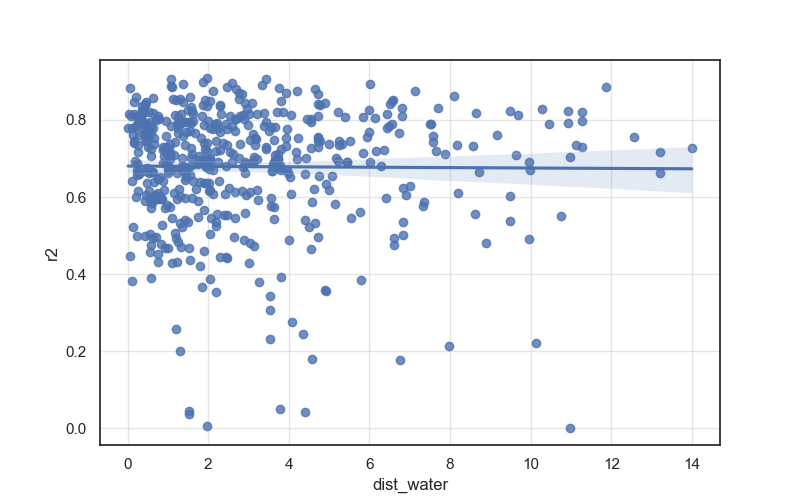

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x="dist_water", y="r2", data=gw_sel.sort_values(by="dist_water")[:], fit_reg=True)
ax.grid(alpha=0.5)

## 7.  Impervious layer 

Check how much the model performance is affected by the imperviousness density (%)

https://land.copernicus.eu/pan-european/high-resolution-layers/imperviousness/status-maps/2006?tab=mapview


In [ ]:
sns.set_theme(style="ticks")
impervious=rasterio.open("D:/Data/students/mariana/data/Raster/Impervious/IMD_2006_100m_eu_03035_d03_E40N30_4647.tif")
#plt.figure(figsize=(3,3))
#show(impervious)

In [ ]:
cl="impervious"
coord_list = [(x,y) for x,y in zip(gw_sel['geometry'].x , gw_sel['geometry'].y)]
gw_sel[cl] = [x[0] for x in impervious.sample(coord_list)]


In [ ]:
gw_selcop=gw_sel.loc[gw_sel[cl]<5]

<IPython.core.display.Javascript object>


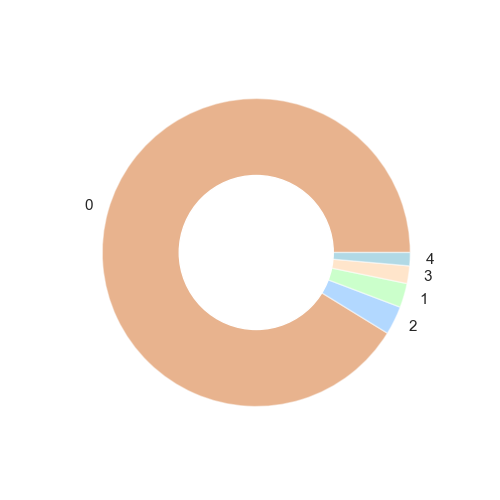

In [ ]:
gw_selimp=pd.DataFrame(gw_selcop[cl].value_counts())
order=gw_selimp.index
plt.figure(figsize=(5,5))
my_circle = plt.Circle( (0,0), 0.5, color='white')
colors = ['chocolate','#66b3ff','#99ff99','#ffcc99','c','olive']
plt.pie(gw_selimp[cl].values, labels=gw_selimp[cl].index, colors=colors,wedgeprops={'alpha':0.5})
p = plt.gcf()
p.gca().add_artist(my_circle)

In [ ]:
lsel=gw_selimp.impervious[0:5].index.astype(int).sort_values()

<IPython.core.display.Javascript object>


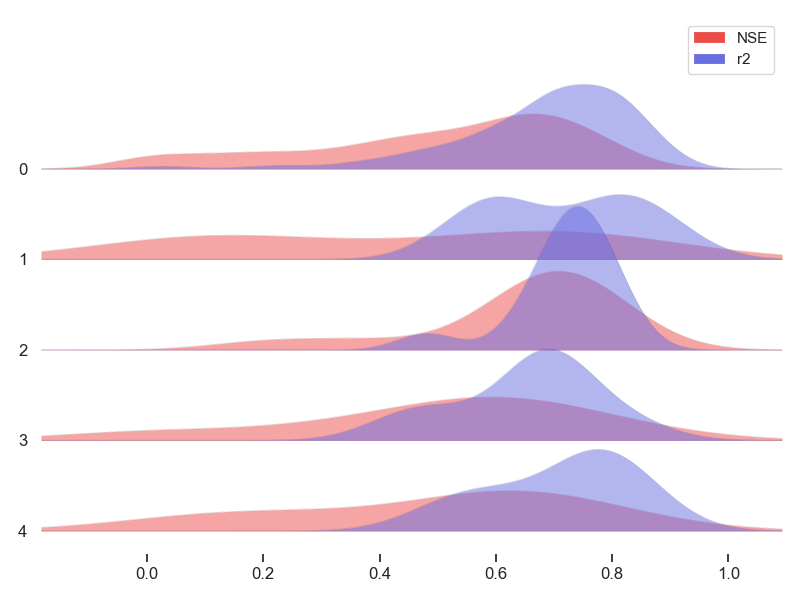

(<Figure size 800x600 with 6 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>])

In [ ]:
gw_sel[cl]=gw_sel[cl].astype(str)
gw_selaux=gw_sel[['NSE','r2', cl]].loc[gw_sel[cl].isin(lsel.astype(str))]
joyplot(
    data=gw_selaux[['NSE','r2', cl]], 
    by=cl,
    color=[ '#eb4d4b','#686de0'],
    lw=0.1,
    alpha=0.5,
    legend=True,
    figsize=(8, 6)
)

## 7.1 Impervious layer with '''km buffer

In [ ]:
gw_sel['imperv_buff']=np.zeros(len(gw_sel))
for i in range(len(gw_sel)):
    out_mask, out_transform = rasterio.mask.mask(impervious, gw_sel['buff_1km'][i:i+1], crop=True)
    meanval=np.mean(out_mask[out_mask!=impervious.meta['nodata']])
    alllist=out_mask[out_mask!=impervious.meta['nodata']]
    paveprop=len(alllist[alllist>0])/len(alllist)
    gw_sel['imperv_buff'][i]=paveprop

<IPython.core.display.Javascript object>


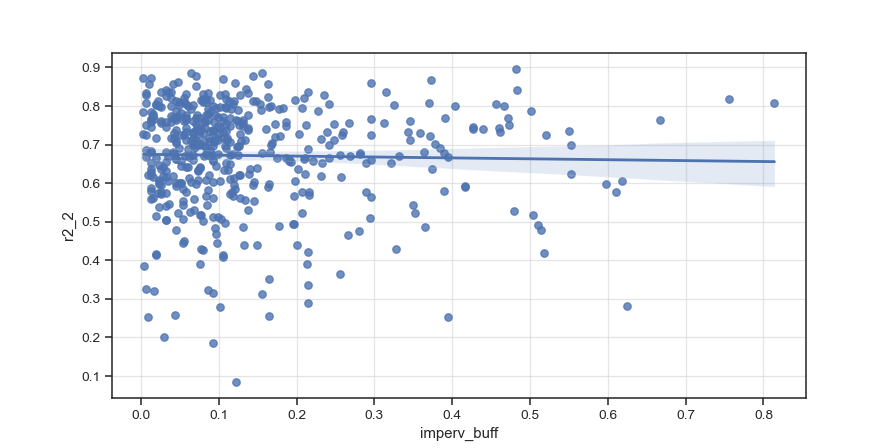

-0.023747218063516998


In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
data=gw_sel[gw_sel['imperv_buff']>0].sort_values(by=['imperv_buff'])
cp=sns.regplot(ax=ax,x='imperv_buff', y="r2_2", data=data, fit_reg=True)
plt.grid(alpha=0.5)

slope, intercept, r_value, p_value, std_err = stats.linregress(data["imperv_buff"],
                                                                   data["r2_2"])
print(r_value)

## 8. Geomorphology

Geomorphography of the Lower Saxony. (Geomorphographische Einheiten von Deutschland)
(GMK1000R V2.0, (C) BGR, Hannover, 2006.) [source]( https://numis.niedersachsen.de/kartendienste?lang=de&topic=naturlandschaft&bgLayer=maps_omniscale_net_osm_webmercator_1&E=1013007.37&N=6912886.50&zoom=7&layers_opacity=fa0188a7f8c1881aa2192dc4d919c5f7&layers=2254e4d9c5a743729f1e886a188ec461)


In [26]:
sns.set_theme(style="ticks")
geomorphology=rasterio.open(pathdat+"/Raster/gmk1000_250_4647.tif")
#geomorphologyc=rasterio.open(pathdat+"Raster/geomorphography/gmk1000_250_4647c.tif")
#geomorphology.plot()
#show(geomorphology)

In [27]:
cl="geomorphology"
coord_list = [(x,y) for x,y in zip(gw_sel['geometry'].x , gw_sel['geometry'].y)]
gw_sel[cl] = [x[0] for x in geomorphology.sample(coord_list)]

1011: very low inclined relief units in very low height above depth contour and high soil moisture index\
1012: low inclined relief units at low altitude  above depth contour and medium soil moisture index\
1021: moderately inclined relief units at medium height  above depth contour and low soil moisture index\
111: Sink areas at very low elevation above  depth contour and with very high soil moisture index\
112: Sink areas at very low elevation above  depth contour and with high soil moisture index\
113: Sink areas at low elevation above depth contour and with high soil moisture index\
114: Sink areas at medium height above depth contour and with medium soil moisture index\
115: Sink areas at medium height above depth contour and with low soil moisture index

In [28]:
dic_geom={1011:'Low Relief/ High-mod SMI',
113: 'Sink areas/ High SMI',
114 : 'Sink areas/ Medium SMI',
112: 'Sink areas/ High SMI',
115: 'Sink areas/ Low SMI' ,
1012: 'Low Relief/ High-mod SMI',
111 : 'Sink areas/ High SMI', 
1021: '                  Moderate Relief/ low SMI' , 
3290: 'Others',
3213: 'Others' , 
116: 'Others' ,
3212:'Others',
3211:'Others',
1022:'Others' }

In [29]:
gw_sel["geomorphology_dic"]=gw_sel[cl].map(dic_geom)

<IPython.core.display.Javascript object>


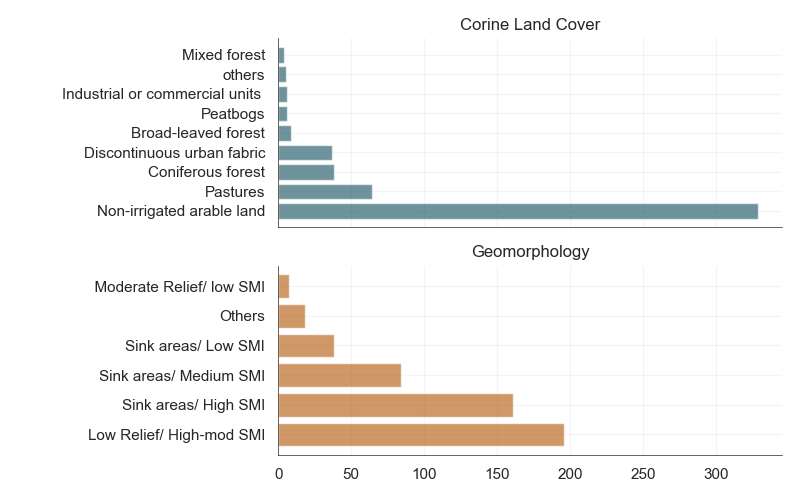

In [ ]:
cl="name"
order=clcsintcl.index

sns.set_theme(style="white")
fig, ax = plt.subplots(2,1,figsize=(8,5),sharex=True)
color=["#0f4c5c"]

piep=ax[0].barh(clcsintcl[cl].index, clcsintcl[cl].values, color=color[0],alpha=0.6)

sns.set_theme(style="white")
cl='geomorphology_dic'
gw_selgeo=pd.DataFrame(gw_sel[cl].value_counts())
order=gw_selgeo.index
color=["#bc6c25"]
piep=ax[1].barh(gw_selgeo[cl].index, gw_selgeo[cl].values, color=color[0], alpha=0.7)

ax[0].set_title("Corine Land Cover")
ax[1].set_title("Geomorphology")
ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_linewidth(0.5)
ax[0].spines['bottom'].set_linewidth(0.5)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_linewidth(0.5)
ax[1].spines['bottom'].set_linewidth(0.5)


plt.tight_layout()  
plt.savefig(pathfig+"clcgeo.pdf",bbox_inches="tight", dpi=300)



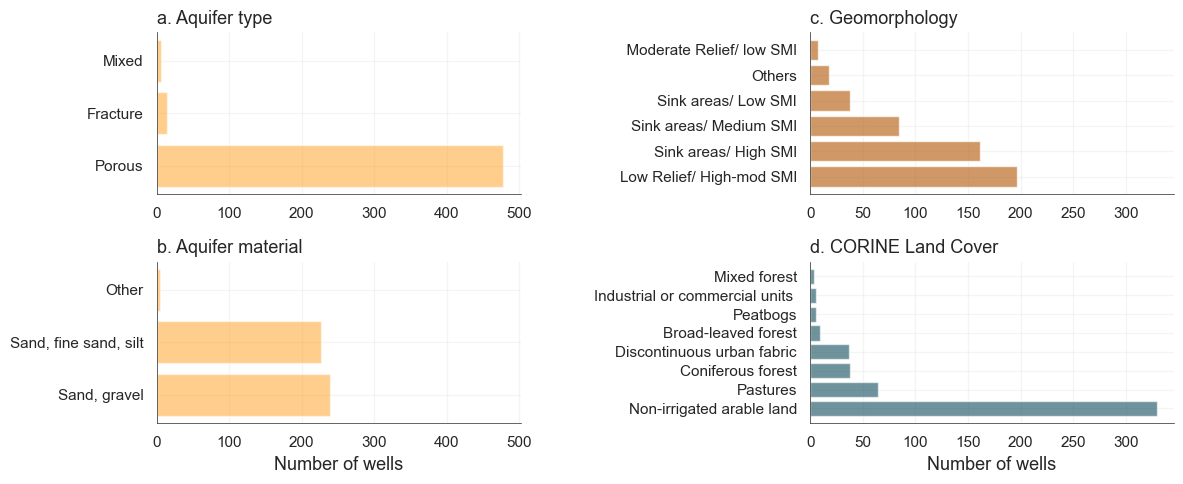

In [125]:

sns.set_theme(style="white")



fig, axs = plt.subplots(2,2,figsize=(12,5),sharex=False)
color=["#0f4c5c","#ff9f1c","#ff9f1c"]

b1=axs[1,1].barh(clcsintcl["name"].index, clcsintcl["name"].values, color="#0f4c5c",alpha=0.6)
gw_selgeo=pd.DataFrame(gw_sel['geomorphology_dic'].value_counts())
axs[0,1].barh(gw_selgeo['geomorphology_dic'].index, gw_selgeo['geomorphology_dic'].values, color="#bc6c25", alpha=0.7)

hgintcl=pd.DataFrame(hgint['HA_bez_dic'].value_counts())
axs[0,0].barh(hgintcl['HA_bez_dic'].index, hgintcl['HA_bez_dic'].values, color="#ff9f1c",alpha=0.5)
hgintcl=pd.DataFrame(hgint['Litho_dic'].value_counts())
axs[1,0].barh(hgintcl['Litho_dic'].index, hgintcl['Litho_dic'].values, color="#ff9f1c",alpha=0.5)

fs=13
axs[0,0].set_title("a. Aquifer type", fontsize=fs,loc='left')
axs[1,0].set_title("b. Aquifer material",fontsize=fs,loc='left')

axs[1,1].set_title("d. CORINE Land Cover",fontsize=fs,loc='left')
axs[0,1].set_title("c. Geomorphology",fontsize=fs,loc='left')
#axs[0,0].set_xlim([0,500])
#axs[1,0].set_xlim([0,500])
#axs[0,1].set_xlim([0,350])

for ax in axs.ravel():
    ax.grid(alpha=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)


axs[1,0].set_xlabel( 'Number of wells',fontsize=fs)
axs[1,1].set_xlabel( 'Number of wells',fontsize=fs)

axs[1,0].get_shared_x_axes().join( axs[1,0], axs[0,0])
axs[1,1].get_shared_x_axes().join( axs[1,1], axs[0,1])
#axs[0,0].get_shared_x_axes().join(axs[0,0], axs[1,0])

plt.tight_layout()  
plt.savefig(pathfig2+"barplots.pdf",bbox_inches="tight")

### 8.1 Geomorphology categorical fraction around 1 km buffer

1011:'Low Relief/ High-mod SMI',\
113: 'Sink areas/ High SMI',\
112: 'Sink areas/ High SMI',\
111 : 'Sink areas/ High SMI',\
114 : 'Sink areas/ Medium SMI',\
115: 'Sink areas/ Low SMI' ,\
1012: 'Low Relief/ High-mod SMI', \
1021: 'Moderate Relief/ low SMI' ,

In [ ]:
#Most relevant geomorphological categories for the study area
categories=[1011,114,111,112,113,115,1012,1021]

for c in categories:
    gw_sel['geo_'+str(c)]=np.zeros(len(gw_sel))
    for i in range(len(gw_sel)):
        out_mask, out_transform = rasterio.mask.mask(geomorphologyc, gw_sel['buff_1km'][i:i+1], crop=True)
        out_meta = geomorphologyc.meta

        arr=np.array(out_mask[0])
        count=np.count_nonzero(arr == c)
        nnan=np.count_nonzero(arr != int(out_meta['nodata']))
        prop_cat=count/nnan   #Proportion of the specific category
        
        if c== 112 or c== 113:  ## put same categories in the same pandas series
            c=111
            
        gw_sel['geo_'+str(c)][i]=prop_cat 
        
gw_sel.drop(['geo_112','geo_113'],axis=1, inplace=True)    
    

<IPython.core.display.Javascript object>


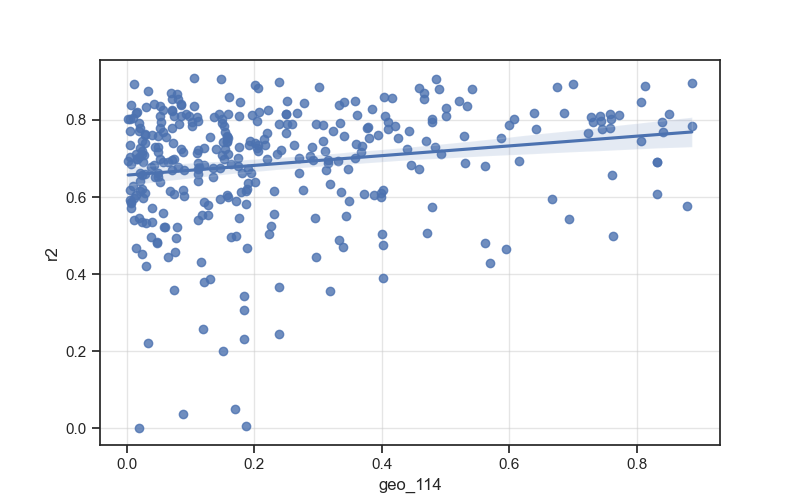

In [ ]:
col='geo_114'
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x=col, y="r2", data=gw_sel[gw_sel[col]>0].sort_values(by=col), fit_reg=True)
plt.grid(alpha=0.5)

## 9. Intersection with long-term recharge

In [ ]:
sns.set_theme(style="ticks")
recharge=rasterio.open("D:/Data/students/mariana/data/Raster/gw_long_term_recharge/bgr/data/GWN1000__3034_v1_raster1_4647.tif")
dem=rasterio.open("D:/Data/students/mariana/data/Raster/dem/lsdem1km_4647.tif")                   


In [ ]:
cl="recharge"
coord_list = [(x,y) for x,y in zip(gw_sel['geometry'].x , gw_sel['geometry'].y)]
gw_sel[cl] = [x[0] for x in recharge.sample(coord_list)]

<IPython.core.display.Javascript object>


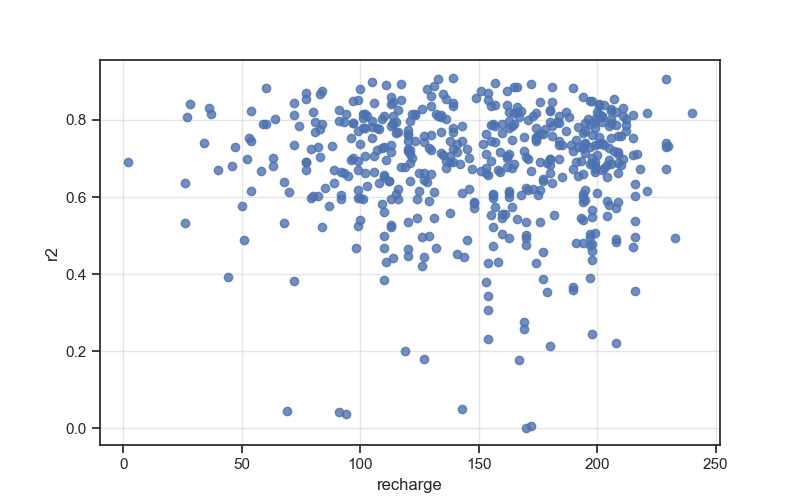

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x=cl, y="r2", data=gw_sel[gw_sel[cl]<900].sort_values(by=cl), fit_reg=False)
plt.grid(alpha=0.5)

### 9.1 Long term recharge with Buffer

In [ ]:
i=2
out_mask_dem, out_transform_dem = rasterio.mask.mask(dem, gw_sel['buff_1km'][i:i+1], crop=True)

In [ ]:
m=np.matrix(out_mask_dem[0])

In [ ]:
pos=np.where(m>np.percentile(out_mask_dem,75))

In [ ]:
gw_sel['recharge_buff']=np.zeros(len(gw_sel))
for i in range(len(gw_sel)):
    out_mask, out_transform = rasterio.mask.mask(recharge, gw_sel['buff_1km'][i:i+1], crop=True)
    #out_mask_dem, out_transform_dem = rasterio.mask.mask(dem, gw_sel['buff_5km'][i:i+1], crop=True)
    #matrix=np.matrix(out_mask_dem[0])
    #pos=np.where(matrix>np.percentile(out_mask_dem,75))
    #nodata=
    meanval=np.mean(out_mask[out_mask!=recharge.meta['nodata']])
    gw_sel['recharge_buff'][i]=meanval
    

<IPython.core.display.Javascript object>


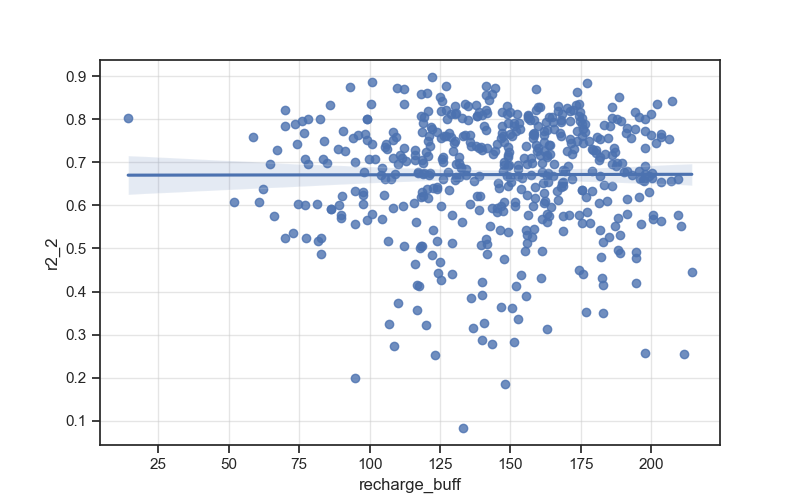

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x='recharge_buff', y="r2_2", data=gw_sel.sort_values(by=['recharge_buff']), fit_reg=True)
plt.grid(alpha=0.5)

## LAI : Leaf Area Index

The information is downloaded from  https://data.jrc.ec.europa.eu/dataset/jrc-mappe-europe-setup-d-18-lai#details .

Corrrespond to average monthly maps of LAI for 2018. 
Original epsg: 3035 -- reprojected here

Pistocchi, Alberto (2015): Leaf Area Index (MAPPE model). European Commission, Joint Research Centre (JRC) [Dataset] PID: http://data.europa.eu/89h/jrc-mappe-europe-setup-d-18-lai

In [ ]:
lai01=rasterio.open(pathrast+"D_18_lai/Export01/lai01_4647_v2.tif")

In [ ]:
gw_sel['lai01_buff']=np.zeros(len(gw_sel))
for i in range(len(gw_sel)):
    out_mask, out_transform = rasterio.mask.mask(lai01, gw_sel['buff_1km'][i:i+1], crop=True)
    meanval=np.mean(out_mask[out_mask!=lai01.meta['nodata']])
    gw_sel['lai01_buff'][i]=meanval

<IPython.core.display.Javascript object>


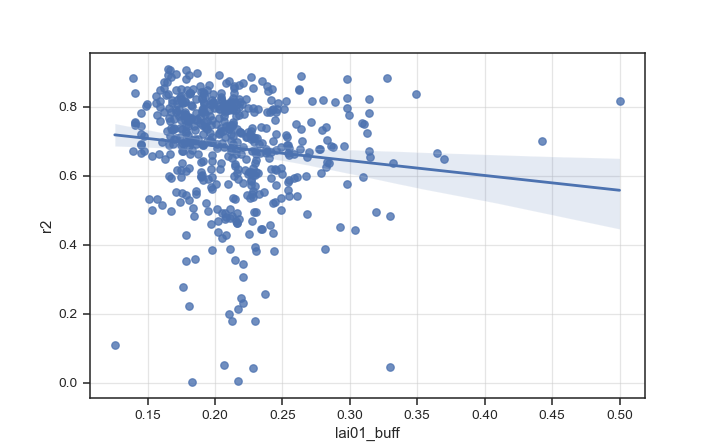

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x='lai01_buff', y="r2", data=gw_sel.sort_values(by=['lai01_buff']), fit_reg=True)
plt.grid(alpha=0.5)

In [ ]:
lai06=rasterio.open(pathrast+"/D_18_lai/Export01/lai06_4647_v2.tif")

In [ ]:
gw_sel['lai06_buff']=np.zeros(len(gw_sel))
for i in range(len(gw_sel)):
    out_mask, out_transform = rasterio.mask.mask(lai06, gw_sel['buff_1km'][i:i+1], crop=True)
    meanval=np.mean(out_mask[out_mask!=lai06.meta['nodata']])
    gw_sel['lai06_buff'][i]=meanval

<IPython.core.display.Javascript object>


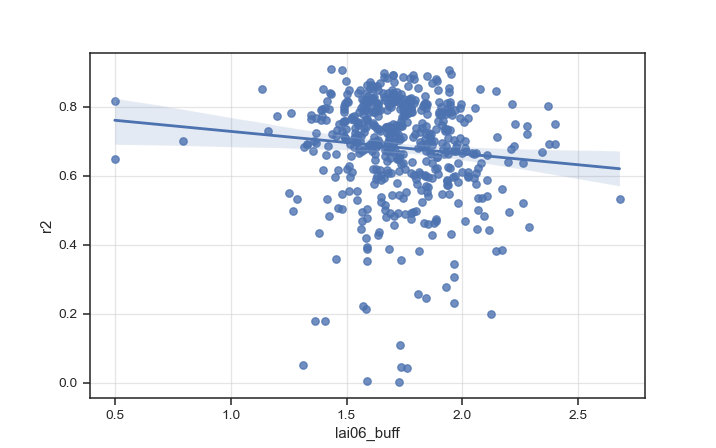

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x='lai06_buff', y="r2", data=gw_sel.sort_values(by=['lai06_buff']), fit_reg=True)
plt.grid(alpha=0.5)

In [ ]:
gw_sel['lai0106_buff']=gw_sel['lai06_buff']-gw_sel['lai01_buff']

<IPython.core.display.Javascript object>


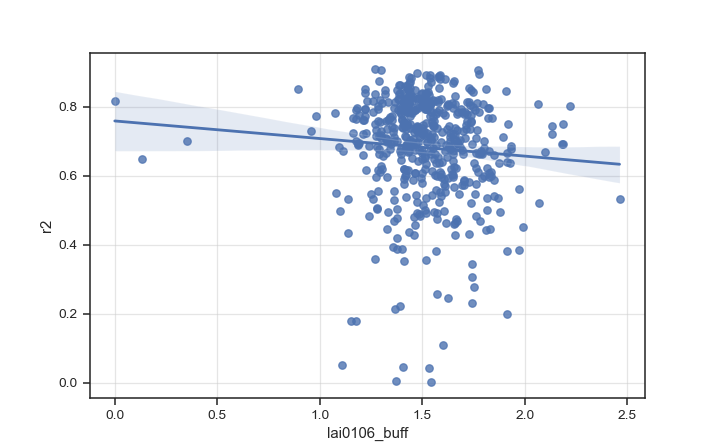

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x='lai0106_buff', y="r2_2", data=gw_sel.sort_values(by=['lai0106_buff']), fit_reg=True)
plt.grid(alpha=0.5)

In [ ]:
dat=gw_sel.sort_values(by=['lai01_buff'])
slope, intercept, r_value, p_value, std_err = stats.linregress(dat["lai01_buff"],
                                                                   dat["r2"])
print(r_value,p_value)

-0.11967086734592605 0.007096419282189292


# Aditional features

In [ ]:
gw_sel_int=gpd.read_file(pathshp+"/gw_sel_intmod2.shp")

## Slope

In [49]:
dem=rd.LoadGDAL(pathrast+"/dem/lsdem1km_4647.tif")
dem[dem==dem[0,0]]=0
slp=rd.TerrainAttribute(dem, attrib="slope_degrees")
slp[slp==0]=np.nan
rd.SaveGDAL(pathrast+"slope.tif", slp)

In [56]:
slp1=rasterio.open(pathrast+"slope.tif")

In [ ]:
gw_sel_int['slope_buff']=np.zeros(len(gw_sel_int))
for i in range(len(gw_sel)):
    out_mask, out_transform = rasterio.mask.mask(slp1, gw_sel['buff_1km'][i:i+1], crop=True)
    meanval=np.mean(out_mask[out_mask!=slp1.meta['nodata']])
    gw_sel_int['slope_buff'][i]=meanval

<IPython.core.display.Javascript object>


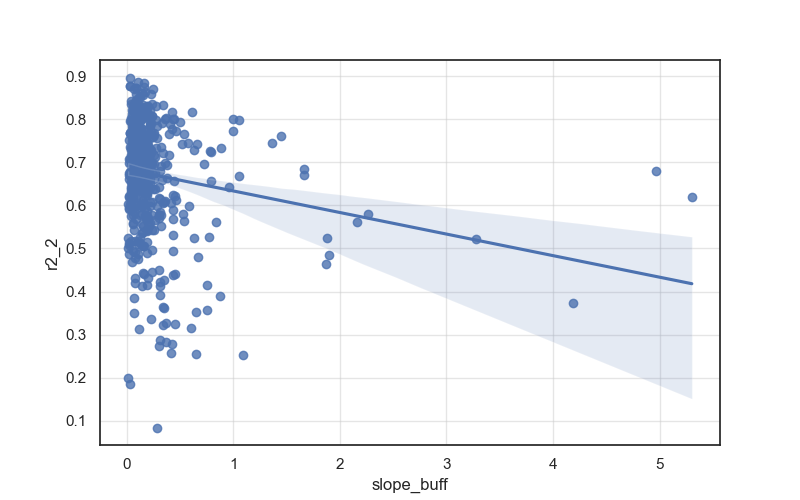

In [190]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x='slope_buff', y="r2_2", data=gw_sel_int.sort_values(by=['slope_buff']), fit_reg=True)
plt.grid(alpha=0.5)

In [198]:
dat=gw_sel_int.sort_values(by=['slope_buff']).dropna(subset=['slope_buff'])
slope, intercept, r_value, p_value, std_err = stats.linregress(dat["slope_buff"],
                                                                   dat["r2_2"])
print(r_value,p_value)

-0.175706578388626 8.083611655966892e-05


## Drainage density

In [229]:
gw_sel_int['drainaged']=np.zeros(len(gw_sel_int))
for i in range(len(gw_sel)):
    clip = gpd.clip(waterways, gw_sel['buff_1km'][i:i+1])
    if len(clip)!=0:
        area= 500*np.pi**2
        dd=sum(clip.length.values)/area
        gw_sel_int['drainaged'][i]=dd
    else:
        gw_sel_int['drainaged'][i]=np.nan

<IPython.core.display.Javascript object>


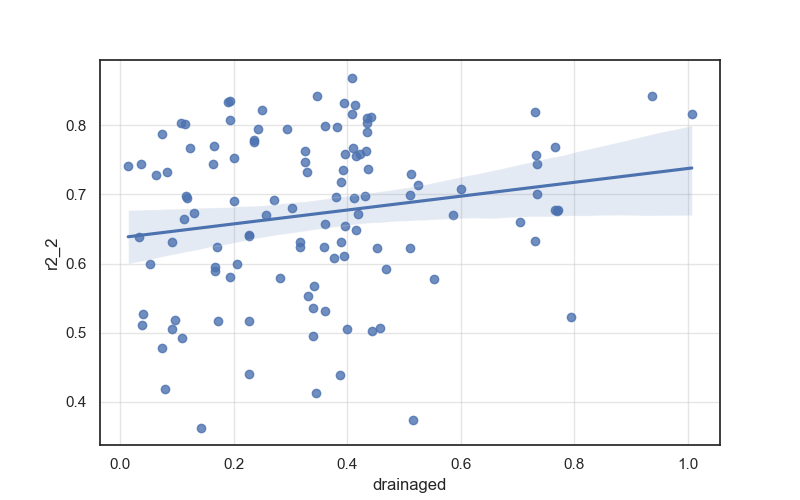

In [231]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x='drainaged', y="r2_2", data=gw_sel_int.sort_values(by=['drainaged']), fit_reg=True)
plt.grid(alpha=0.5)

In [233]:
dat=gw_sel_int.sort_values(by=['drainaged']).dropna(subset=['drainaged'])
slope, intercept, r_value, p_value, std_err = stats.linregress(dat["drainaged"],
                                                                   dat["NSE_2"])
print(r_value,p_value)

0.19439184387146236 0.03571374062352602


##  Topographic wetness index 

In [63]:
command = ["gdal_translate"] + [ "-of", "PCRaster"] + [pathrast+"/dem/lsdem1km_4647.tif", pathrast+"/dem/lsdem1km_4647_pc.map"]
result = subprocess.run(command)

In [64]:
dem= pc.readmap(pathrast+"/dem/lsdem1km_4647_pc.map")

In [78]:
slpfrac=pc.slope(dem)
slpper=slpfrac*100
slprad= slpper*0.062831853071796
# Compute the flow direction raster from the DEM
flow_dir = pc.lddcreate(dem, 1e31, 1e31,1e31, 1e31)
# Compute the flow accumulation raster
flow_accum = pc.accuflux(flow_dir,1)
#pc.report(flow_dir, pathrast+"/dem/flowacc_4647_pc.map")

TWI= pc.ln((flow_accum*pc.cellarea()) / pc.tan(slprad) )
pc.report(TWI,pathrast+"/dem/twi.map") 


In [101]:
dataset = gdal.Open(pathrast+"/dem/twi.map", gdal.GA_ReadOnly)
driver = gdal.GetDriverByName("GTiff")
output_dataset = driver.CreateCopy( pathrast+"/dem/twi.tiff", dataset)
output_dataset=None

In [127]:
twir=rasterio.open(pathrast+"/dem/twi.tiff")
gw_sel_int['twi']=np.zeros(len(gw_sel_int))
for i in range(len(gw_sel_int)):
    out_mask, out_transform = rasterio.mask.mask(twir, gw_sel['buff_1km'][i:i+1], crop=True)
    meanval=np.mean(out_mask[out_mask!=twir.meta['nodata']])
    gw_sel_int['twi'][i]=meanval



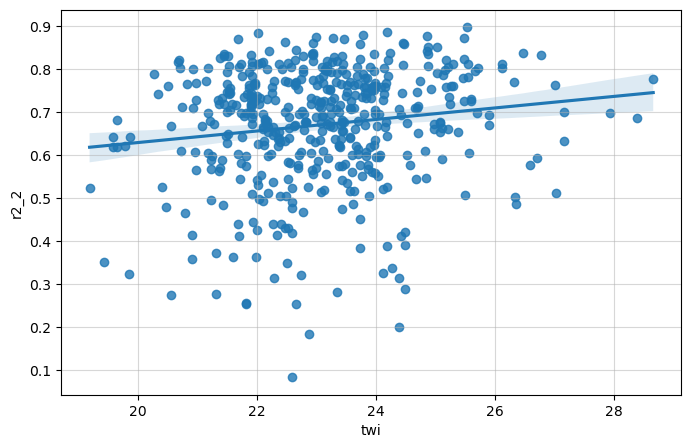

In [131]:
fig, ax = plt.subplots(figsize=(8,5))
cp=sns.regplot(ax=ax,x='twi', y="r2_2", data=gw_sel_int.sort_values(by=['twi']), fit_reg=True)
plt.grid(alpha=0.5)

In [133]:
dat=gw_sel_int.sort_values(by=['twi']).dropna(subset=['twi'])
slope, intercept, r_value, p_value, std_err = stats.linregress(dat["twi"],
                                                                   dat["r2_2"])
print(r_value,p_value)

0.14530362281111778 0.0014288684055317412


## Save the data 

In [178]:
#Remove uncompatible columns
l=list(gw_sel.columns)
for i in range(1,6):
    l.remove('buff_'+str(i)+'km')

In [179]:
#Save the information excluding the buffer columns
gw_sel[l].to_file('./data/SHP/gw_sel_int.shp')  